# Coche autónomo mediante Deep Learning

Autor: Andrés Martínez Martínez

##Imports

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# common use
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# images
from imgaug import augmenters as iaa
from PIL import Image
import cv2

# machine learning
import tensorflow as tf
from sklearn.model_selection import train_test_split

print( f'tf.version: {tf.__version__}')

model_output_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/trained models'

tf.version: 2.8.2


##Load data

In [3]:
# import images and get a list with its paths
data_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/data'

# get training angles from file names, 90 degrees is follow straight
file_list = os.listdir(data_dir + '/manual-images-v2/images')
file_list = sorted(file_list)
image_paths = [f'{data_dir}/manual-images-v2/images/{name}' for name in file_list if name[-4:] == '.png'] # we only want files with .png extension
steering_angles = [int(name[-7:-4]) for name in image_paths]

#get validation angles
vfile_list = os.listdir(data_dir + '/validation/images')
vfile_list = sorted(vfile_list)
vimage_paths = [f'{data_dir}/validation/images/{name}' for name in vfile_list if name[-4:] == '.png']
vsteering_angles = [int(name[-7:-4]) for name in vfile_list]

number of images: 8695
number of angles: 8695


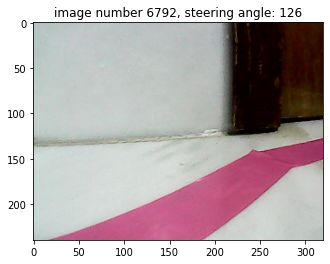

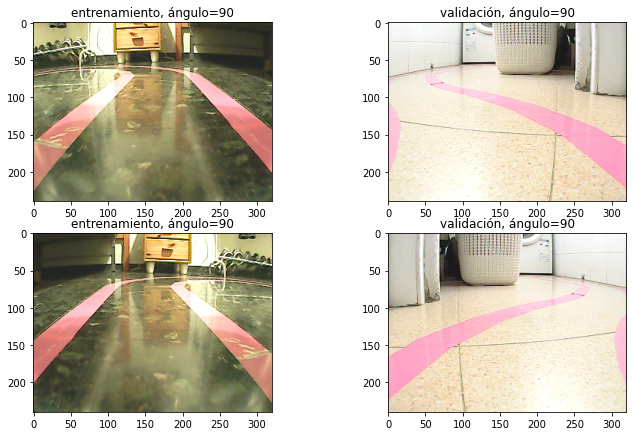

In [4]:
print('number of images: %d' % len(image_paths))
print('number of angles: %d' % len(steering_angles))

# show an image and its angle
index = np.random.randint(0, len(image_paths) - 1)
plt.imshow(Image.open(image_paths[index]))
plt.title('image number %d, steering angle: %d' % (index, steering_angles[index]))
plt.show()

ncol = 2
nrow = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(10, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB))
    axes[i][0].set_title(f"entrenamiento, ángulo={steering_angles[i]}")
    axes[i][1].imshow(cv2.cvtColor(cv2.imread(vimage_paths[i]), cv2.COLOR_BGR2RGB))
    axes[i][1].set_title(f"validación, ángulo={vsteering_angles[i]}")

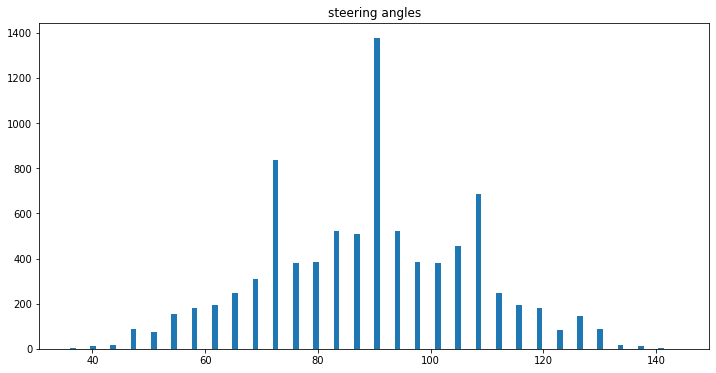

In [5]:
# check distribution of steering angles
fig, axes = plt.subplots(figsize=(12,6))
plt.hist(steering_angles, bins=30, width=1)
plt.title('steering angles')
plt.show()

##Prepare datasets

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/manual-images-v2', 
    labels=steering_angles, 
    label_mode='int', 
    color_mode='rgb',
    image_size=(240,320),
    seed=123)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/validation', 
    labels=vsteering_angles, 
    label_mode='int', 
    color_mode='rgb',
    image_size=(240,320),
    seed=123) 

Found 8695 files belonging to 1 classes.
Found 774 files belonging to 1 classes.


## Visualize datasets

In [7]:
images = []
while len(images) < 4:
  for images, labels in train_dataset.take(1):
    im_shape = images[1].shape
    for i in range(4):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(labels[i].numpy())
      plt.axis('off')

KeyboardInterrupt: ignored

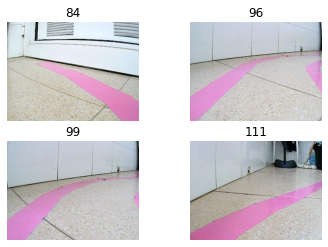

In [8]:
images = []
while len(images) < 4:
  for images, labels in val_dataset.take(1):
    im_shape = images[1].shape
    for i in range(4):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(labels[i].numpy())
      plt.axis('off')

#Model

In [30]:
#from keras.backend import relu
def model_nvidia():

  model = tf.keras.Sequential(name='Model_Nvidia')
  
  # model.add(tf.keras.layers.RandomContrast(0.1))
  
  # preprocessing layers
  model.add(tf.keras.layers.Cropping2D(cropping=((120,0),(0,0))))
  model.add(tf.keras.layers.Resizing(66,200))
  model.add(tf.keras.layers.Rescaling(1./127.5,offset=-1))

  # conv layers
  
  model.add(tf.keras.layers.Conv2D(24, 5, strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Conv2D(64, 3, activation='elu'))
  model.add(tf.keras.layers.Conv2D(64, 3, activation='elu'))

  # fully connected layers
  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(100, activation='elu'))
  model.add(tf.keras.layers.Dense(50, activation='elu'))
  model.add(tf.keras.layers.Dense(10, activation='elu'))

  # output layer
  model.add(tf.keras.layers.Dense(1))

  # loss
  opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=opt)

  return model

In [31]:
model = model_nvidia()
model.build((32,240,320,3))
print(model.summary())
history = None

Model: "Model_Nvidia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_5 (Cropping2D)   (32, 120, 320, 3)         0         
                                                                 
 resizing_5 (Resizing)       (32, 66, 200, 3)          0         
                                                                 
 rescaling_5 (Rescaling)     (32, 66, 200, 3)          0         
                                                                 
 conv2d_25 (Conv2D)          (32, 31, 98, 24)          1824      
                                                                 
 conv2d_26 (Conv2D)          (32, 14, 47, 36)          21636     
                                                                 
 conv2d_27 (Conv2D)          (32, 5, 22, 48)           43248     
                                                                 
 conv2d_28 (Conv2D)          (32, 3, 20, 64)          

##Training

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
trained_model_name = 'lane-nav-Nvidia-inv'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, trained_model_name + '-checkpoint.h5'), verbose=1, save_best_only=True)

history = model.fit(train_dataset,
                              epochs=20,
                              verbose=1,
                              validation_data=val_dataset,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir, trained_model_name + '.h5'))

Epoch 1/20
  9/272 [..............................] - ETA: 2:33 - loss: 5182.1660

KeyboardInterrupt: ignored

# Review learning curves

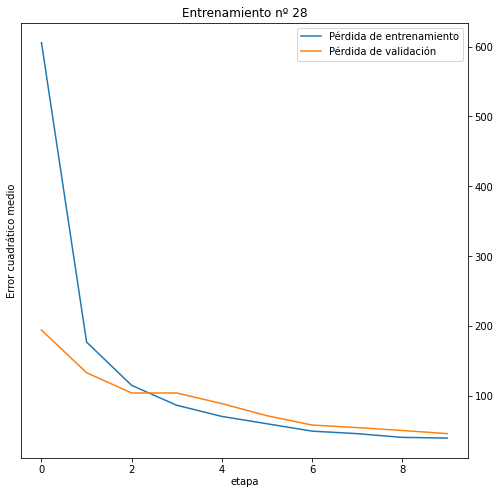

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(loss, label='Pérdida de entrenamiento')
ax.plot(val_loss, label='Pérdida de validación')
plt.legend(loc='upper right')
plt.ylabel('Error cuadrático medio')
plt.title('Entrenamiento nº 28')
plt.xlabel('etapa',labelpad=2)
ax.yaxis.tick_right()
plt.show()

# Conversión a TF Lite

In [15]:
os.chdir(f'{model_output_dir}/model3-inverted-other-seed')
model = tf.keras.models.load_model('lane-navigation-checkpoint.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('lane-navigation-model-v3.tflite', 'wb') as f:
  f.write(tflite_model)

FileNotFoundError: ignored